In [50]:
import cv2
import os
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from  collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


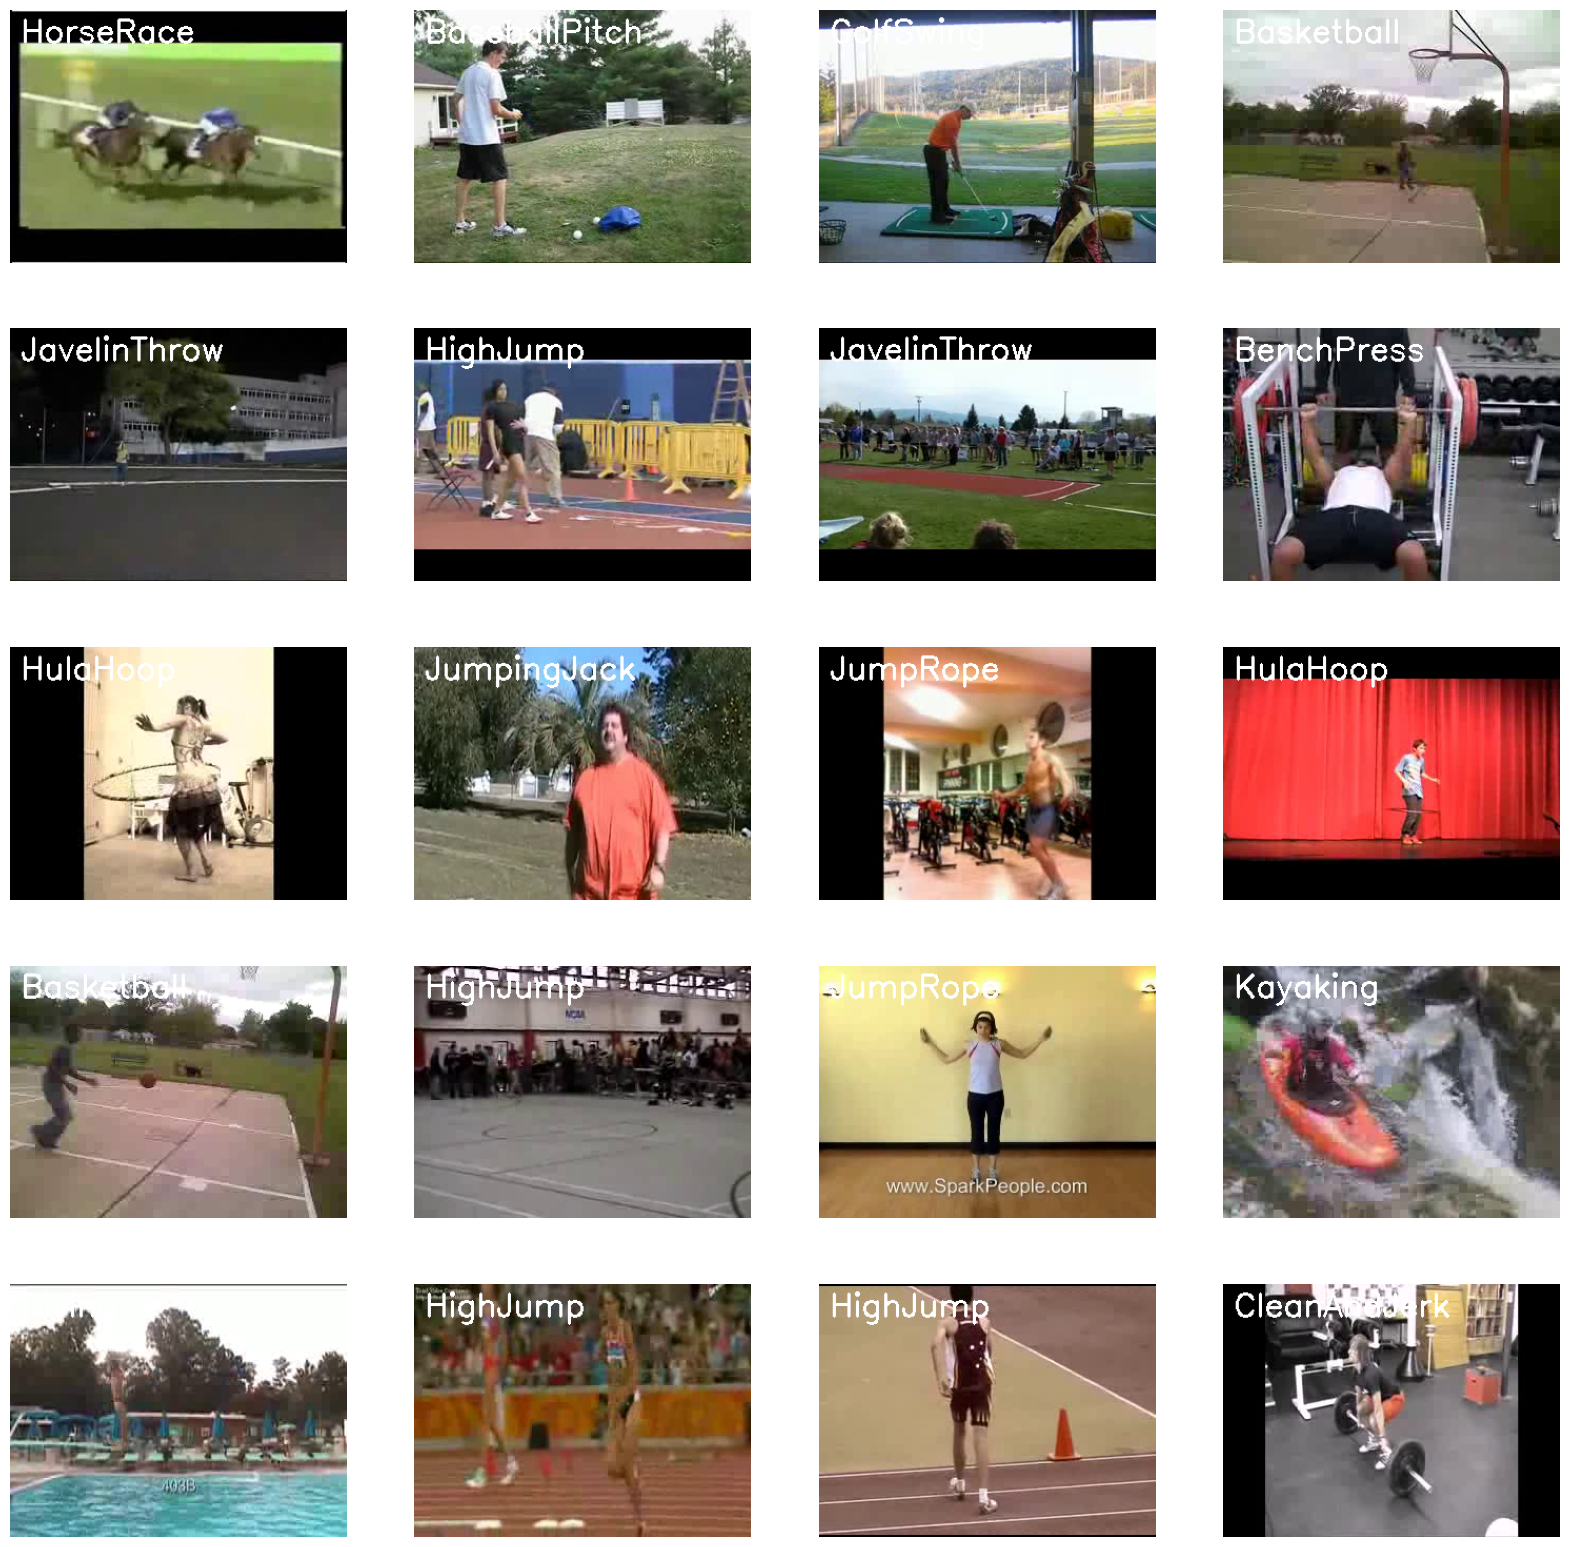

In [4]:
plt.figure(figsize=(20, 20))

all_classes_names = os.listdir("./l8/dataset/UCF50/")[:20]

random_range = random.sample(range(len(all_classes_names)), 19)
random_range = [random.randint(0, len(all_classes_names)) for _ in range(20)]

for counter, random_index in enumerate(random_range, 1):
    select_class_name = all_classes_names[random_index]

    video_files_name_list = os.listdir(f"./l8/dataset/UCF50/{select_class_name}")
    selected_video_files_name = random.choice(video_files_name_list)
    video_render = cv2.VideoCapture(f"./l8/dataset/UCF50/{select_class_name}/{selected_video_files_name}")

    _, bgr_frame = video_render.read()
    video_render.release()

    cv2.putText(bgr_frame, select_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [16]:
IMAHE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20

DATASET_DIR = "./l8/dataset/UCF50/"

CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRiding"]

In [6]:
def frame_extract(video_path):
    frames_list = []

    video_render = cv2.VideoCapture(video_path)
    video_frames_count = int(video_render.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_render.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_render.read()

        if not success: break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAHE_HEIGHT))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)
    
    video_render.release()

    return frames_list

In [7]:
frames_list = frame_extract(os.path.join(DATASET_DIR, "BaseballPitch/v_BaseballPitch_g01_c01.avi"))

pass

In [18]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frame_extract(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [9]:
from tensorflow.keras.layers import ConvLSTM3D, MaxPooling3D, TimeDistributed, Dropout, ConvLSTM2D, Flatten, Dense

In [10]:
def create_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation="tanh",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))


    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation="tanh",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation="tanh",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    model.summary()

    return model
              

In [11]:
conv_lstm_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

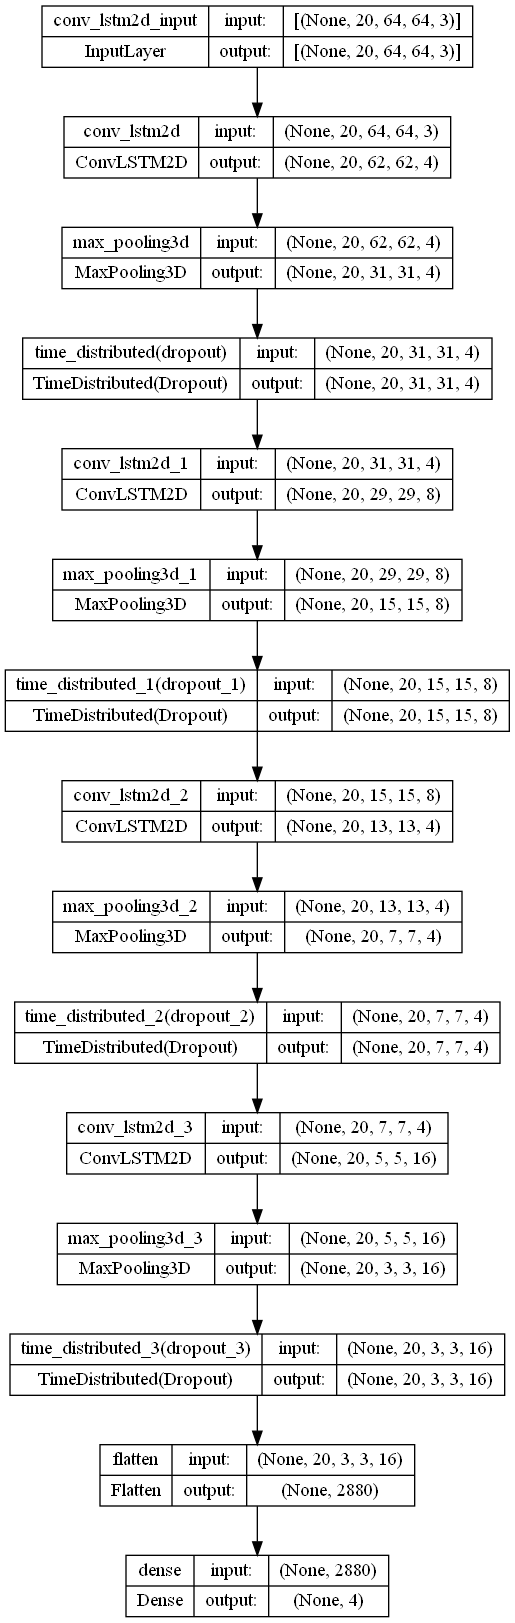

In [12]:
plot_model(conv_lstm_model, to_file='conv_lstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
from sklearn.model_selection import train_test_split

features, labels, files = create_dataset()
one_hot_encoding_labels = to_categorical(labels)

features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoding_labels, test_size=0.25, shuffle=True)

In [21]:
with tf.device("/gpu:0"):
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True)

    conv_lstm_model.compile(
        loss='categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy'])

    conv_lstm_model_training_history = conv_lstm_model.fit(
        x=features_train,
        y=labels_train,
        epochs=5,
        batch_size=4,
        shuffle=True,
        validation_split=0.2,
        callbacks=[early_stopping_callback])

Epoch 1/5
84/84 [==============================] - 83s 863ms/step - loss: 1.3410 - accuracy: 0.3784 - val_loss: 1.3371 - val_accuracy: 0.2619
Epoch 2/5
84/84 [==============================] - 71s 849ms/step - loss: 1.2191 - accuracy: 0.4595 - val_loss: 1.2335 - val_accuracy: 0.3810
Epoch 3/5
84/84 [==============================] - 71s 851ms/step - loss: 1.1017 - accuracy: 0.5255 - val_loss: 1.3851 - val_accuracy: 0.3810
Epoch 4/5
84/84 [==============================] - 70s 839ms/step - loss: 1.0083 - accuracy: 0.5736 - val_loss: 1.1104 - val_accuracy: 0.4524
Epoch 5/5
84/84 [==============================] - 69s 819ms/step - loss: 0.9246 - accuracy: 0.6156 - val_loss: 1.2068 - val_accuracy: 0.4286


In [24]:
model_evaluate_history = conv_lstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 3s 614ms/step - loss: 1.0692 - accuracy: 0.5500


In [25]:
loss, accuracy = model_evaluate_history

datetime_format = "%Y_%m_%d__%H_%M_%S"
current_datetime_dt = dt.datetime.now()
current_datetime_dt_string = dt.datetime.strftime(current_datetime_dt, datetime_format)

model_from_file = f"model__DATE_DIME_{current_datetime_dt_string}__Loss_{loss}__Accuracy_{accuracy}"

In [26]:
conv_lstm_model.save(model_from_file)

INFO:tensorflow:Assets written to: model__DATE_DIME_2024_04_12__15_59_29__Loss_1.0691874027252197__Accuracy_0.550000011920929\assets


In [28]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

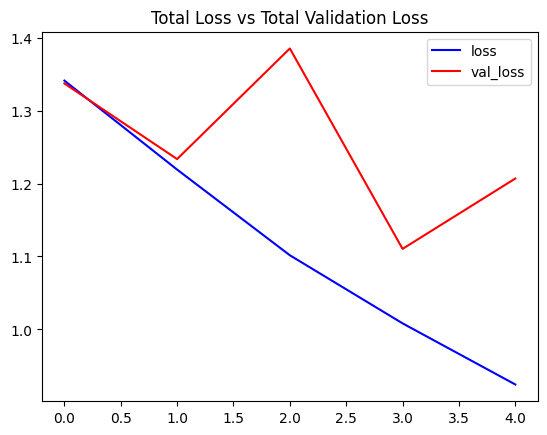

In [29]:
plot_metric(conv_lstm_model_training_history, 'loss',
            'val_loss', 'Total Loss vs Total Validation Loss')

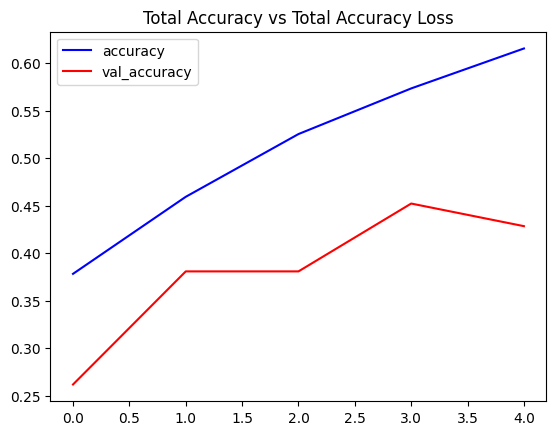

In [30]:
plot_metric(conv_lstm_model_training_history, 'accuracy',
            'val_accuracy', 'Total Accuracy vs Total Accuracy Loss')

In [34]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM

In [35]:
def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), activation="relu", padding='same', input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3))))
    
    model.add(TimeDistributed(MaxPooling2D(4, 4)))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding='same', input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3))))
    model.add(TimeDistributed(MaxPooling2D(4, 4)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding='same', input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3))))
    model.add(TimeDistributed(MaxPooling2D(4, 4)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding='same', input_shape = (SEQUENCE_LENGTH, IMAHE_HEIGHT, IMAGE_WIDTH, 3))))
    model.add(TimeDistributed(MaxPooling2D(4, 4)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    model.summary()

    return model

In [36]:
conv_lstm_model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 20, 31, 31, 4)    0         
 3D)                                                             
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

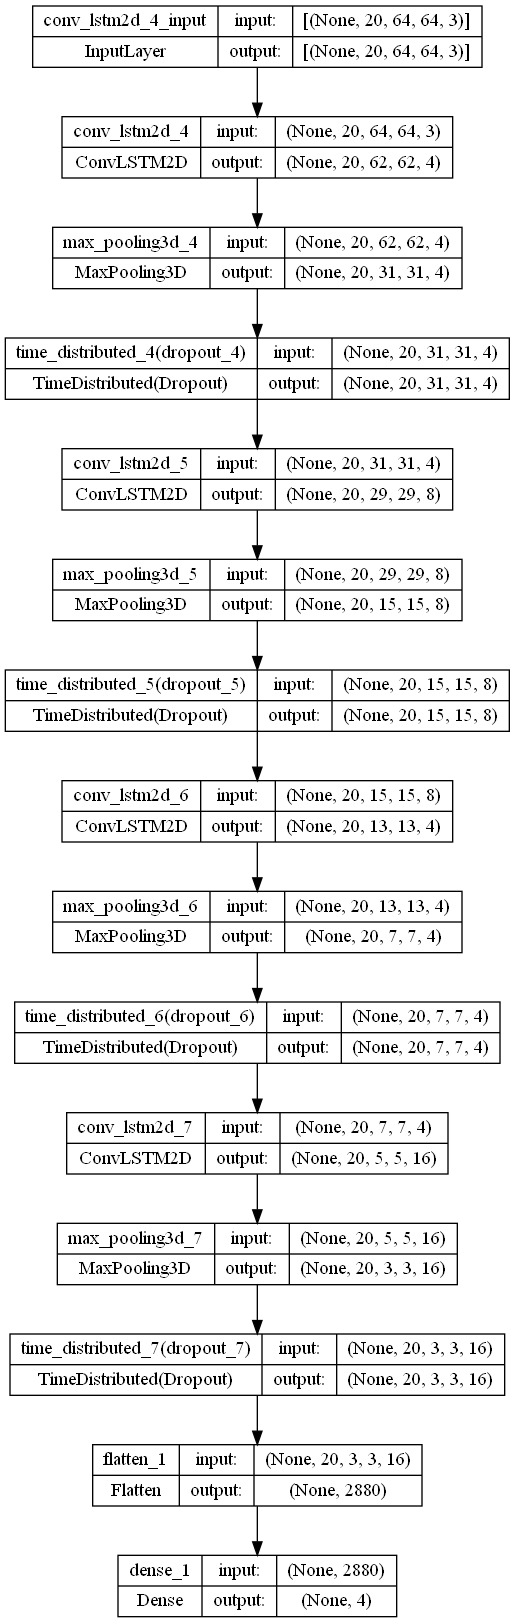

In [37]:
plot_model(conv_lstm_model, to_file='conv_lstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [53]:
physical_devices = tf.config.list_physical_devices('GPU')
if(physical_devices):
    detales = tf.config.experimental.get_device_details(physical_devices[0])
    print(f"Код GPU: {physical_devices[0].name}")
    print(f"Имя GPU: {detales['device_name']}")

In [54]:
with tf.device("/gpu:0"):
  conv_lstm_model = create_model()

  early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=15,
        mode='min',
        restore_best_weights=True)

  conv_lstm_model.compile(
      loss='categorical_crossentropy',
      optimizer='Adam',
      metrics=['accuracy'])


conv_lstm_model_training_history = conv_lstm_model.fit(
    x=features_train,
    y=labels_train,
    epochs=5,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_16 (ConvLSTM2D)  (None, 20, 62, 62, 4)    1024      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 20, 31, 31, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 31, 31, 4)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_17 (ConvLSTM2D)  (None, 20, 29, 29, 8)    3488      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 20, 15, 15, 8)    0         
 g3D)                                                            
                                                      

In [63]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH, model):
    video_renderer = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_render.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_render.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_renderer.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_deque = deque(maxlen=SEQUENCE_LENGTH)

    predicted_class_name = ""

    while video_render.isOpened():
        ok, frame = video_render.read()

        if not ok: break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAHE_HEIGHT))
        normalized_frame = resized_frame / 255

        frames_deque.append(normalized_frame)

        if len(frames_deque) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_deque, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]
        
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)

    video_render.release()
    video_writer.release()


In [66]:
predict_on_video("C:/VSCodeProjects/PatternRecognition/Lab-8/l8/test_videos/videoplayback.mp4", "./test.mp4", SEQUENCE_LENGTH, conv_lstm_model)